In [1]:
# 라이브러리 불러오기
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from tensorflow import keras
import cv2
import pickle
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.patches as mpatches
from keras.callbacks import EarlyStopping

In [2]:
!nvidia-smi

Thu Aug 12 04:07:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터 압축 풀기
!unzip -qq /content/drive/MyDrive/DeepPCB-master.zip

In [5]:
# PATH 에 데이터 경로 저장
PATH = '/content/DeepPCB-master/PCBData'

In [6]:
# 데이터를 정상, 불량, 불량분류 list로 나누는 작업
# 가장 중요함 데이터 전처리임

# os.listdir()은 지정한 디렉토리 내의 모든 파일과 디렉토리의 리스트를 리턴
# path_2에 group folder 이름을 저장함

#path_2 안에 있는 그룹 폴더 안을 또 들여다 본다
#그런데 왜? path가 3,4로 나뉘어지는 것인가...
#아하!
#group00041 폴더 안으로 들어가게 되면 파일이 2개가 있다.
#00041, 00041_not
#path_3는 00041, path_4에는 00041_not이 들어가는것이다.

#path_3에서 파일 이름에 temp가 있는 경우 -> 정상 이미지
#path_3에서 파일 이름에 test가 있는 경우 -> 불량 이미지

#따라서 normal list에는 temp 이미지 파일 경로 저장, defect list에는 test 이미지 파일 경로 저장

#이제 path_4에는 defect log 를 가진 txt의 파일 경로를 저장한다.

#여기서 defect log는 defect의 boundary box 좌표 데이터를 가지고 있다.

# 마지막으로 normal defect defectlog 를 sort 해준다.

normal = []
defect = []
defectlog = []
path_2 = [os.path.join(PATH,dir) for dir in os.listdir(PATH) if '.' not in dir]
for p in tqdm(path_2,total=len(path_2)):
    path_3 = os.path.join(p,sorted(os.listdir(p))[0])
    normal +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'temp' in dir]
    defect +=[os.path.join(path_3,dir)for dir in os.listdir(path_3) if 'test' in dir]
    path_4 = os.path.join(p,sorted(os.listdir(p))[1])
    defectlog +=[os.path.join(path_4,dir)for dir in os.listdir(path_4)]

normal.sort()
defect.sort()
defectlog.sort()

In [7]:
# normal_img에는 normal한 이미지 데이터들을 array형태로 저장하게 된다.
# list로 저장했다가 np.array 형태로 변화 시켜준다

# defect_img에는 defect한 이미지 데이터들을 array형태로 저장한다.
# 마찬가지로 np.array로 데이터 저장

# 두 이미지 모두 resize로 데이터의 크기를 128x128로 설정해준다.

normal_img = []
defect_img = []
for img_path in tqdm(normal,total=len(normal)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    normal_img.append(img)
for img_path in tqdm(defect,total=len(defect)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    defect_img.append(img)
normal_img = np.array(normal_img)
defect_img = np.array(defect_img)

In [8]:
# PATH 위치에 img0 img1 의 Array를 pickle 모듈로 저장하는 코드 이다.
# pickle 모듈로 저장하는 이유는 array는 따로 불러오거나 읽는게 folder과 다르기 때문이다.

with open(PATH+'normal_img.pkl', 'wb') as f:
    pickle.dump(normal_img, f, pickle.HIGHEST_PROTOCOL)
with open(PATH+'defect_img.pkl', 'wb') as f:
    pickle.dump(defect_img, f, pickle.HIGHEST_PROTOCOL)

In [9]:
# 이미지 데이터 말고 이제 defect log 데이터를 array에 저장해보자
# defet log는 좌표 데이터이다.
# x1 y1 x2 y2 즉 사각형 좌표이다.
# 그리고 defect는 숫자로 표현 되어있는데, 어떤 defect인지 알려준다.

box_point = []
i=0
for log in tqdm(defectlog,total=len(defectlog)):
    temp = pd.read_csv(log,sep=' ' ,names=['x1', 'y1', 'x2', 'y2', 'defect'], header=None).values.tolist()
    box_point.append(temp)
    i+=1

In [10]:
# box에는 일단 좌표와 defect저장
# 이제 boxarr에 box를 arr로 저장하자
# narr 크기는 640x640x1를 0으로 초기화 

#cv2.rectangle 공부
#cv2.rectangle(img, start, end, color, thickness)
#img – 그림을 그릴 이미지
#start – 시작 좌표(ex; (0,0))
#end – 종료 좌표(ex; (500. 500))
#color – BGR형태의 Color(ex; (255, 0, 0) -> Blue)
#thickness (int) – 선의 두께. pixel


#narr에 그림을 그릴 곳
#start좌표는 x1 y1
#end 좌표는 x2 y2
#color는 d로 했는데 여기서 d는 오류의 종류임
#선의 두께 :-1
#근데 왜 cv2.resize 88x88로 설정했을까
#이게 너무 궁금,,,
#boxarr은 target값인데, 마지막으로 나와야하는 size가 88x88라는 말과도 같은거

#640x640=409,600
#88x88 = 7744

#box는 1500개의 리스트 개수
#1500개인데 각 리스트 안에 5개씩 값이 있으니까
#7500개?


#아니 640x640x1 3차원 어레이에 사각형을 그리고 resize를 한다고...?

boxarr = []
for i in tqdm(range(len(box_point))): #1500번
    narr = np.zeros((640,640,1))
    for j in range(len(box_point[i])):#5번
        x1,y1,x2,y2,d = box_point[i][j]
        narr = cv2.rectangle(narr,(x1,y1),(x2,y2),d,-1)
    narr = cv2.resize(narr,(88,88))
    boxarr.append(narr)
boxarr = np.array(boxarr)

In [11]:
ans1 = np.array(boxarr[0])
ans1.shape

(88, 88)

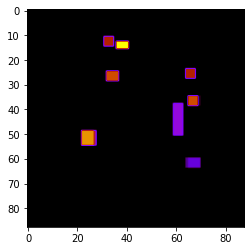

In [12]:
plt.imshow(boxarr[4],cmap='gnuplot')
plt.show()

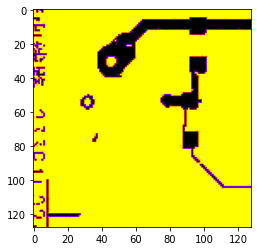

In [13]:
plt.imshow(np.reshape(defect_img[4],(128,128)),cmap='gnuplot')
plt.show()

In [14]:
#dataset은 defect_img이 feature, boxarr이 target

dataset = tf.data.Dataset.from_tensor_slices((defect_img,boxarr))

In [15]:
print(dataset)

<TensorSliceDataset shapes: ((128, 128), (88, 88)), types: (tf.uint8, tf.float64)>


In [16]:
# 총 데이터 개수 n에 저장 (1500개)
#dataset 셔플 해줘야함, 재현성을 위해 seed=47로 설정
#take(): 해당 배치를 몇 번 불러올지 정한다. 
#(배치를 1500*0.8 = 1200번 불러온다)
#이때 batch 100

#test_data는 skip()함수로1200개를 skip

#여기서 의문점
#dataset.take를 왜 하는거고
#data.skip은 또 왜하는거냐
#skip은 아에 넘어가는건데...

#아 설마
#훈련 데이터는 1200개
#테스트 데이터는 300개?


n=1500
dataset = dataset.shuffle(n,seed=47)

train_dataset = dataset.take(int(n*0.8)).batch(100)
test_dataset = dataset.skip(int(n*0.8)).batch(100)

# n=1500
# dataset = dataset.shuffle(n,seed=47)

# test_dataset = dataset.take(int(n*0.33)).batch(100)
# train_dataset = dataset.skip(int(n*0.33)).batch(100)



# n=1500
# dataset = dataset.shuffle(n,seed=47)

# train_dataset_1 = dataset.take(int(n*0.33)).batch(100)
# test_dataset = dataset.skip(int(n*0.33)).take(int(n*0.33)).batch(100)
# train_dataset_2 = dataset.skip(int(n*0.66)).batch(100)
# train_dataset = train_dataset_1.concatenate(train_dataset_2)

In [17]:
dataset

<ShuffleDataset shapes: ((128, 128), (88, 88)), types: (tf.uint8, tf.float64)>

In [18]:
print(len(train_dataset))
print(len(test_dataset))


12
3


In [19]:
## layer5 cnn bn he flip
inputs = keras.layers.Input((128,128,1))
# x = keras.layers.experimental.preprocessing.Resizing(128,128)(inputs)
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')(x)

x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #126 126 64
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #124 124 64
x = keras.layers.Activation('relu')(x)
x1 = tf.identity(x)
x1 = keras.layers.experimental.preprocessing.CenterCrop(92,92)(x1)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #62 62,64

x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #60 60 128
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #58 58 128
x = keras.layers.Activation('relu')(x)
x2 = tf.identity(x)
x2 = keras.layers.experimental.preprocessing.CenterCrop(50,50)(x2)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #29 29 128

x = keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #27 27 256
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #25 25 256
x = keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 50 50 128

x = keras.layers.Concatenate()([x,x2]) #50 50 256
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #48 48 128
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #46 46 128
x = keras.layers.Activation('relu')(x)

x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 92 92 64

x = keras.layers.Concatenate()([x,x1]) #92,92 128
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #90 90 64
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal())(x) #88 88 64
x = keras.layers.Activation('relu')(x)

outputs = keras.layers.Conv2D(filters=7,kernel_size=1,kernel_initializer=tf.keras.initializers.HeNormal())(x) #88 88 7

In [20]:
defect_img.shape

(1500, 128, 128)

In [21]:
boxarr.shape

(1500, 88, 88)

In [22]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 128, 128, 1)  0           rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 64) 640         random_flip[0][0]                
______________________________________________________________________________________________

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
# validation data가 없는데 monitor = 'val_loss'가 맞는 것일까?
#es = EarlyStopping(patience=100,monitor='val_loss',min_delta=0.005,mode='min',verbose=1)
callback = tf.keras.callbacks.ModelCheckpoint(PATH+'model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch',)
history = model.fit(train_dataset,epochs=500,validation_data=test_dataset,callbacks=callback)
#history = model.fit(train_dataset,epochs=500,validation_data=test_dataset,verbose=0)

Epoch 1/500
12/12 [==============================] - 25s 317ms/step - loss: 0.4544 - accuracy: 0.8962 - val_loss: 0.1959 - val_accuracy: 0.9743

Epoch 00001: val_loss improved from inf to 0.19590, saving model to /content/DeepPCB-master/PCBDatamodel.h5
Epoch 2/500
12/12 [==============================] - 3s 288ms/step - loss: 0.1767 - accuracy: 0.9744 - val_loss: 0.1646 - val_accuracy: 0.9747

Epoch 00002: val_loss improved from 0.19590 to 0.16456, saving model to /content/DeepPCB-master/PCBDatamodel.h5
Epoch 3/500
12/12 [==============================] - 3s 288ms/step - loss: 0.1628 - accuracy: 0.9743 - val_loss: 0.1607 - val_accuracy: 0.9742

Epoch 00003: val_loss improved from 0.16456 to 0.16073, saving model to /content/DeepPCB-master/PCBDatamodel.h5
Epoch 4/500
12/12 [==============================] - 3s 287ms/step - loss: 0.1597 - accuracy: 0.9743 - val_loss: 0.1582 - val_accuracy: 0.9745

Epoch 00004: val_loss improved from 0.16073 to 0.15824, saving model to /content/DeepPCB-ma

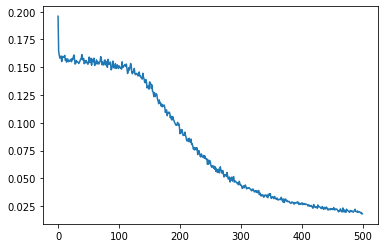

In [25]:
plt.plot(history.history['val_loss'])
plt.show()

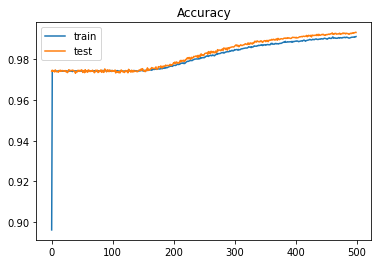

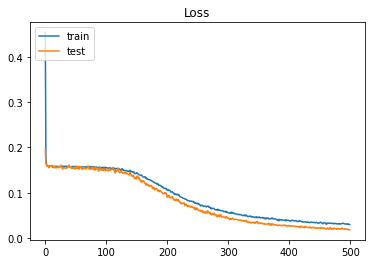

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


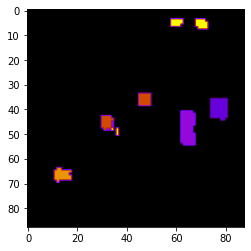

In [27]:
out = model.predict(tf.reshape(defect_img[0],(-1,128,128,1)))

out2 = np.argmax(out,axis=3)
print(out2[0])
plt.imshow(out2[0],cmap='gnuplot')

In [28]:
img_arr_resized = cv2.resize(defect_img[0],(88,88))
img_arr_resized = cv2.cvtColor(img_arr_resized,cv2.COLOR_GRAY2RGB)

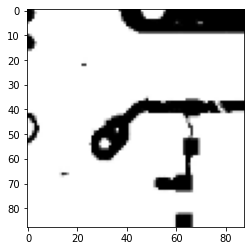

In [29]:
plt.imshow(img_arr_resized)

In [30]:
pred = model.predict(tf.reshape(defect_img[0],(-1,128,128,1)))
pred = np.argmax(pred,axis=3)[0]

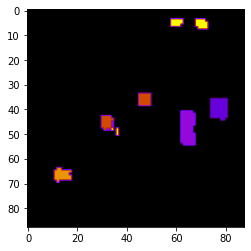

In [31]:
plt.imshow(pred,cmap='gnuplot')

In [32]:
new_pred = np.zeros((88,88,3),dtype=np.uint8)

In [33]:
new_pred[pred==0] = img_arr_resized[pred==0]
new_pred[pred==1] = [255,228,0] #open
new_pred[pred==2] = [1,0,255] #short
new_pred[pred==3] = [29,219,22] #mousebite
new_pred[pred==4] = [255,0,0] #spur
new_pred[pred==5] = [103,0,0] #copper
new_pred[pred==6] = [255,0,127] #pin-hole

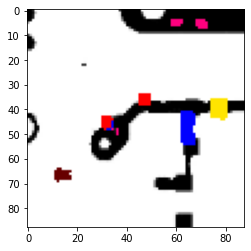

In [34]:
plt.imshow(new_pred,cmap='gnuplot')

In [35]:
blend_img1=Image.fromarray(img_arr_resized)
blend_img2=Image.fromarray(new_pred)
blend_img=Image.blend(blend_img1,blend_img2,0.5)

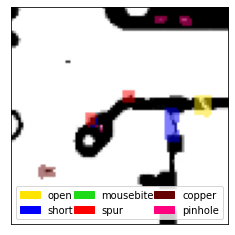

In [36]:
legend1 = mpatches.Patch(color='#FFE400', label='open')
legend2 = mpatches.Patch(color='#0100FF', label='short')
legend3 = mpatches.Patch(color='#1DDB16', label='mousebite')
legend4 = mpatches.Patch(color='#FF0000', label='spur')
legend5 = mpatches.Patch(color='#670000', label='copper')
legend6 = mpatches.Patch(color='#FF007F', label='pinhole')
plt.legend(loc='lower left', handles=[legend1,legend2,legend3,legend4,legend5,legend6],mode = "expand", ncol = 3,fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(np.array(blend_img))
plt.show()

In [37]:
len(defectlog)

1500

In [38]:
log_df = pd.DataFrame(columns=['0','1','2','3','4','5','6'])
i=0
for log in tqdm(defectlog,total=len(defectlog)):
    temp_df = pd.read_csv(log,sep=' ' ,names=['x1', 'y1', 'x2', 'y2', 'defect'], header=None)
    temp = np.zeros(7,dtype=int)
    for t in temp_df['defect']:
        temp[t]+=1
    log_df.loc[i,:] = temp
    i+=1

In [39]:
dataset2 = tf.data.Dataset.from_tensor_slices((defect_img,log_df.values.astype(np.int)))

In [40]:
n=1500
dataset2 = dataset2.shuffle(n)
train_dataset2 = dataset2.take(int(n*0.8)).batch(100)
test_dataset2 = dataset2.skip(int(n*0.8)).batch(100)

In [41]:
load_model = tf.keras.models.Model(
    [model.inputs],
    [model.layers[16].output]
)

In [42]:
for layer in load_model.layers:
    layer.trainable=False

In [43]:
x = load_model.output #25 25 256
x = keras.layers.MaxPooling2D((3, 3), strides=2)(x) #12 12 256
x_l = keras.layers.BatchNormalization()(x)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=256,kernel_size=1,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x_l = keras.layers.BatchNormalization()(x_l)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x = keras.layers.Concatenate()([x, x_l]) #12 12 320

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(filters=160,kernel_size=1,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #6 6 160

x_l = keras.layers.BatchNormalization()(x)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=160,kernel_size=1,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x_l = keras.layers.BatchNormalization()(x_l)
x_l = keras.layers.Activation('relu')(x_l)
x_l = keras.layers.Conv2D(filters=40,kernel_size=3,padding='same',kernel_initializer=tf.keras.initializers.HeNormal())(x_l)
x = keras.layers.Concatenate()([x, x_l]) #6 6 200

x = keras.layers.GlobalAveragePooling2D()(x) #1*1*200
outputs = keras.layers.Dense(7,activation='linear')(x)

In [44]:
model2 = keras.Model(load_model.inputs, outputs)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 128, 128, 1)  0           rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 64) 640         random_flip[0][0]                
____________________________________________________________________________________________

In [45]:
model2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy']
)

In [46]:
# callback2 = tf.keras.callbacks.ModelCheckpoint(path+'model2.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='loss', save_freq='epoch',)
# history2 = model2.fit(train_dataset2,epochs=1000,validation_data=test_dataset2,callbacks=[callback2])
history2 = model2.fit(train_dataset2,epochs=500,validation_data=test_dataset2,verbose=1)

Epoch 1/500
12/12 [==============================] - 2s 72ms/step - loss: 0.8226 - accuracy: 0.2867 - val_loss: 2.5360 - val_accuracy: 0.0167
Epoch 2/500
12/12 [==============================] - 1s 56ms/step - loss: 0.5079 - accuracy: 0.3183 - val_loss: 1.7773 - val_accuracy: 0.0800
Epoch 3/500
12/12 [==============================] - 1s 57ms/step - loss: 0.4588 - accuracy: 0.3225 - val_loss: 1.4074 - val_accuracy: 0.4533
Epoch 4/500
12/12 [==============================] - 1s 56ms/step - loss: 0.4368 - accuracy: 0.3692 - val_loss: 1.0475 - val_accuracy: 0.3533
Epoch 5/500
12/12 [==============================] - 1s 56ms/step - loss: 0.4173 - accuracy: 0.3475 - val_loss: 0.9533 - val_accuracy: 0.2367
Epoch 6/500
12/12 [==============================] - 1s 56ms/step - loss: 0.4046 - accuracy: 0.3742 - val_loss: 0.7115 - val_accuracy: 0.2633
Epoch 7/500
12/12 [==============================] - 1s 56ms/step - loss: 0.3837 - accuracy: 0.3892 - val_loss: 0.6766 - val_accuracy: 0.2700
Epoch 

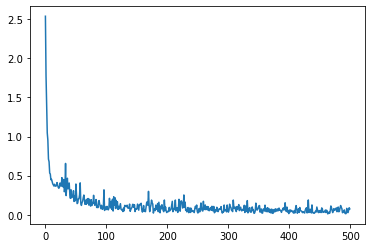

In [47]:
plt.plot(history2.history['val_loss'])
plt.show()

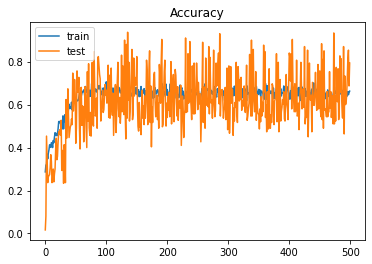

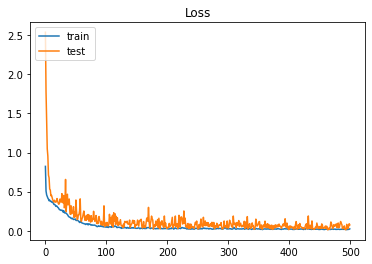

In [48]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [62]:
model2_pred = model2.predict(tf.reshape(defect_img[1],(-1,128,128,1)))
model2_pred

array([[0.00283762, 1.2123693 , 0.31797448, 2.0512404 , 1.3463328 ,
        1.1418535 , 1.0711123 ]], dtype=float32)

In [63]:
np.round(model2_pred).astype(np.int)

array([[0, 1, 0, 2, 1, 1, 1]])

In [64]:
log_df.values[1]

array([0, 1, 0, 2, 1, 1, 1], dtype=object)

In [52]:
# #교차검증
# from sklearn.datasets import load_iris
# from sklearn.model_selection import cross_val_score
# from tensorflow.keras.models import load_model

# # 모델
# CV_model = load_model('/content/DeepPCB-master/PCBDatamodel.h5')

# # 파라미터는 (모델, Traingdata의 feature, Trainingdata의 target, 폴드수) 이다.
# results = cross_val_score(CV_model, defect_img,boxarr ,cv=5)

# # Trainingdata에 대한 성능을 나타낸다.
# print('교차 검증별 정확도:',np.round(results, 3))
# print('평균 검증 정확도:', np.round(np.mean(results), 3))